###Required package
h5py
Keras
numpy
opencv-python
sklearn


In [132]:

#Test image from model
from __future__ import division
import os
import cv2
import numpy as np
import pandas as pd
import sys
import pickle

import time
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
##
%matplotlib widget
#load library
import ipywidgets as widgets
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder
import matplotlib.pyplot as plt

sys.setrecursionlimit(40000)
config_output_filename = "config.pickle"
number_of_roi = 32

with open(config_output_filename, 'rb') as f_in:
     C = pickle.load(f_in)

if C.network == 'resnet50':
    import keras_frcnn.resnet as nn
elif C.network == 'vgg':
     import keras_frcnn.vgg as nn

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

def format_img_size(img, C):
#""" formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio	

def format_img_channels(img, C):
 #""" formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
  #""" formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
#print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = number_of_roi

if C.network == 'resnet50':
    num_features = 1024
elif C.network == 'vgg':
    num_features = 512

if K.common.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True
#get the hand location in the image by calling this function
def image_hand_segnet(image_file):
    columns=['x1',  'y1', 'x2','y2','class_name','accuracy']
    predicted_data_frame = pd.DataFrame(columns = columns)
    st = time.time()
    img = image_file

    X, ratio = format_img(img, C)

    if K.common.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
            class_name = "" 
            if int(key) == 0 :
                class_name = "open palm"
            if int(key) == 1 :
                class_name = "fist palm"
            if int(key) == 2 :
                class_name = "three_fingers palm"
            if int(key) == 3 :
                class_name = "open dorsal"
            if int(key) == 4 :
                class_name = "fist dorsal"
            if int(key) == 5 :
                class_name = "three_fingers dorsal"
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            predicted_data_frame = predicted_data_frame.append({columns[0] : real_x1, columns[1] : real_y1, columns[2] :real_x2, columns[3] : real_y2, columns[4] : class_name , columns[5] :  str(100*new_probs[jk])}, ignore_index=True)
            #cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2),(0,0,255) ,2)
    return predicted_data_frame



Loading weights from ./model_frcnn.hdf5


In [133]:
def ReShape_image(cropped_frame):
        # read image
        img = cropped_frame
        ht, wd, cc= img.shape
        # create new image of desired size and color (white) for padding
        ww = 480
        hh = 480
        #Image background
        color = (255,255,255)
        result = np.full((hh,ww,cc), color, dtype=np.uint8)
        # copy img topleft of result image
        result[0:ht, 0:wd] = img
        return result

# Input Image and call : get hand location and output class
This section we shall call the image_hand_segnet to get the hand location and output class

In [134]:
video_subdirecory_name = "videos"
video_file_extensions = [".mp4",".webm"]
#directory_names= ["102","159","294","441","564","576","609","666","711","723"]
directory_names= ["723"]
#conditions = ["open_palm","open_dorsal","fist_palm","fist_dorsal","three_fingers_palm","three_fingers_dorsal"]
conditions = ["three_fingers_palm"]

   x1   y1   x2   y2          class_name           accuracy
0  38  153  307  422  three_fingers palm  99.83999133110046
Hand sement


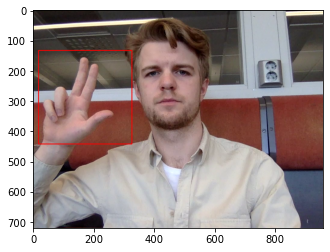

Hand sement


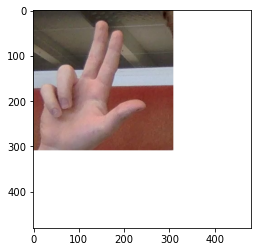

In [135]:
for directory_name in directory_names:
    for video_name in conditions:
        for extension in video_file_extensions:
            video_path =directory_name + "\\" + video_name 
            input_video = cv2.VideoCapture(r"" + video_subdirecory_name + "\\" + video_path + extension)
            ret, frame = input_video.read()
            counter = 0
            while ret:
                ret, frame = input_video.read()
                if not ret:
                    continue
                #get handlocation and prediction
                predicted_data_frame = image_hand_segnet(frame)
                
                if predicted_data_frame.empty == False :
                    print(predicted_data_frame)
                    X1 = int(predicted_data_frame.iloc[0, 0])
                    Y1 = int(predicted_data_frame.iloc[0, 1])
                    X2 = int(predicted_data_frame.iloc[0, 2])
                    Y2 = int(predicted_data_frame.iloc[0, 3])
                    cropped_frame = frame[Y1 - 20 : Y2 + 20, X1 - 20 : X2 + 20]
                    reshaped_cropped= ReShape_image(cropped_frame)
                    cv2.rectangle(frame,(X1 - 20,Y1 - 20), (X2 + 20,Y2 + 20 ),(0,0,255) ,2)
                    image_original = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    image_reshape_cropped = cv2.cvtColor(reshaped_cropped, cv2.COLOR_BGR2RGB)
                    print("Hand sement")
                    %matplotlib inline
                    plt.imshow(image_original)
                    plt.show()                    
                    print("Hand sement")
                    %matplotlib inline
                    plt.imshow(image_reshape_cropped)
                    plt.show() 
                    break
            input_video.release()



# Raw Image from webcam



In [136]:
# For Visualization in Jupyter
import ipywidgets as widgets
from IPython.display import display
# Get images and video into Jupyter from your webcam
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder


In [137]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [138]:
recorder2 = VideoRecorder(stream=camera)
recorder2


VideoRecorder(stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, …

   x1   y1   x2   y2 class_name           accuracy
0  64  166  204  307  fist palm  89.30345177650452
Hand sement: original Image


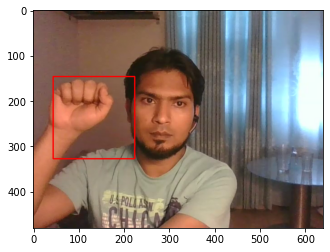

Hand sement : cropped image


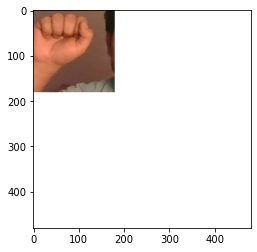

In [139]:
camera.close()
# write the file to disk
with open('capture.webm', 'wb') as out_file:
    out_file.write(recorder2.video.value)
    
video_reader = cv2.VideoCapture("capture.webm")
ret, frame = video_reader.read()
while ret:
    ret, frame = video_reader.read()
    if not ret:
        continue
    predicted_data_frame = image_hand_segnet(frame)
    if predicted_data_frame.empty == False :
        print(predicted_data_frame)
        X1 = int(predicted_data_frame.iloc[0, 0])
        Y1 = int(predicted_data_frame.iloc[0, 1])
        X2 = int(predicted_data_frame.iloc[0, 2])
        Y2 = int(predicted_data_frame.iloc[0, 3])
        cropped_frame = frame[Y1 - 20 : Y2 + 20, X1 - 20 : X2 + 20]
        reshaped_cropped= ReShape_image(cropped_frame)
        cv2.rectangle(frame,(X1 - 20,Y1 - 20), (X2 + 20,Y2 + 20 ),(0,0,255) ,2)
        image_original = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_reshape_cropped = cv2.cvtColor(reshaped_cropped, cv2.COLOR_BGR2RGB)
        print("Hand sement: original Image")
        %matplotlib inline
        plt.imshow(image_original)
        plt.show()                    
        print("Hand sement : cropped image")
        %matplotlib inline
        plt.imshow(image_reshape_cropped)
        plt.show() 
        break
video_reader.release()

